<a href="https://colab.research.google.com/github/kridtapon/Vector-Gravity-Sync/blob/main/Vector_Gravity_Sync.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.0 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Download the data
symbol = 'NEM'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# ========================
# 1. Calculate DMI Stochastic
# ========================

def calculate_dmi_stochastic(df, period=14, smooth_k=3, smooth_d=3):
    high = df['High']
    low = df['Low']
    close = df['Close']

    # +DM and -DM
    up_move = high.diff()
    down_move = low.diff()
    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0)

    # TR (True Range)
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    atr = pd.Series(tr).rolling(window=period).mean()
    plus_di = 100 * pd.Series(plus_dm).rolling(window=period).sum() / atr
    minus_di = 100 * pd.Series(minus_dm).rolling(window=period).sum() / atr
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = dx.rolling(window=period).mean()

    # Stochastic on ADX
    lowest_adx = adx.rolling(window=period).min()
    highest_adx = adx.rolling(window=period).max()
    stoch_adx = 100 * (adx - lowest_adx) / (highest_adx - lowest_adx)
    k = stoch_adx.rolling(window=smooth_k).mean()
    d = k.rolling(window=smooth_d).mean()
    return k, d

# ========================
# 2. Calculate Center of Gravity (COG)
# ========================

def calculate_cog(df, length=10):
    price = df['Close']
    weights = np.arange(1, length + 1)
    def cog_series(prices):
        if len(prices) < length:
            return np.nan
        return np.sum(prices * weights[::-1]) / np.sum(prices)
    cog = price.rolling(window=length).apply(cog_series, raw=True)
    return cog

# ========================
# 3. Apply Indicators
# ========================

df['COG'] = calculate_cog(df, length=25)
df['COG_Delta'] = df['COG'] - df['COG'].shift(10)
df['COG_Up'] = df['COG_Delta'] > 0
df['COG_Down'] = df['COG_Delta'] < 0

df['DMI_K'], df['DMI_D'] = calculate_dmi_stochastic(df)

# Entry = DMI_K crosses up DMI_D AND COG is curving up
df['Entry'] = (df['DMI_K'] > df['DMI_D']) | df['COG_Up']

# Exit = DMI_K tops out (crosses down DMI_D) AND COG turns down
df['Exit'] = (df['DMI_K'] < df['DMI_D']) | df['COG_Down']

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Shift entries and exits to next bar
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# Create portfolio using 'Open' prices
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


/tmp/ipython-input-15-2929494852.py:10: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                  159864.513516
Total Return [%]                               59.864514
Benchmark Return [%]                           -0.433232
Max Gross Exposure [%]                             100.0
Total Fees Paid                             14222.421282
Max Drawdown [%]                               47.617208
Max Drawdown Duration                  667 days 00:00:00
Total Trades                                          42
Total Closed Trades                                   41
Total Open Trades                                      1
Open Trade PnL                              -4856.888466
Win Rate [%]                                   63.414634
Best Trade [%]                                 39.601081
Worst Trade [%]                

/tmp/ipython-input-23-1778363945.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


✅ Best DMI Parameters: period=14, smooth_k=4, smooth_d=3, return=116.05%


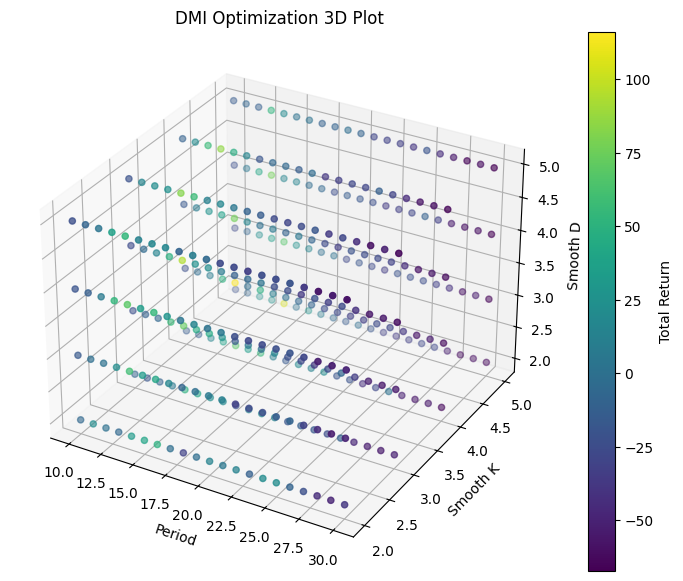

✅ Best COG Parameters: length=7, delta_shift=8, return=149.03%


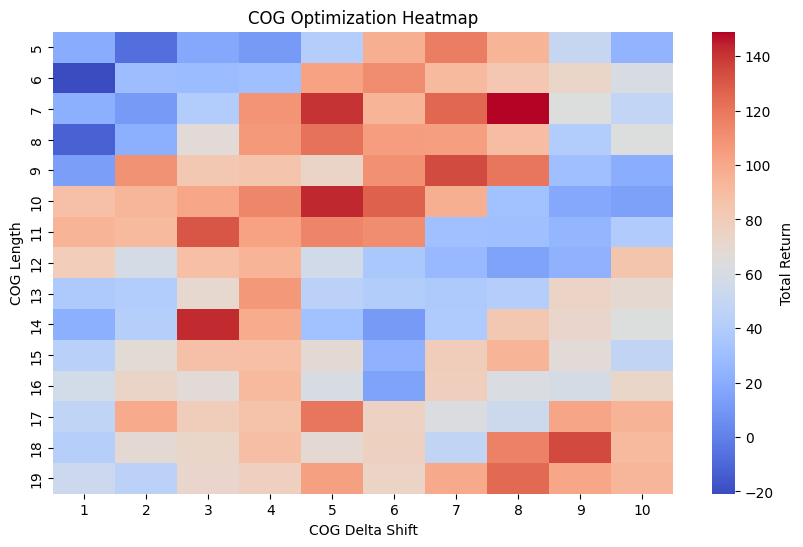

In [23]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

# Download the data
symbol = 'NEM'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

def calculate_dmi_stochastic(df, period=10, smooth_k=2, smooth_d=2):
    high = df['High']
    low = df['Low']
    close = df['Close']

    up_move = high.diff()
    down_move = low.diff()

    plus_dm = pd.Series(np.where((up_move > down_move) & (up_move > 0), up_move, 0), index=high.index)
    minus_dm = pd.Series(np.where((down_move > up_move) & (down_move > 0), down_move, 0), index=high.index)

    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    atr = tr.rolling(window=period).mean()
    plus_di = 100 * plus_dm.rolling(window=period).sum() / atr
    minus_di = 100 * minus_dm.rolling(window=period).sum() / atr

    # Avoid division by zero by replacing 0 denominators with NaN
    denominator = plus_di + minus_di
    denominator = denominator.replace(0, np.nan)

    dx = 100 * abs(plus_di - minus_di) / denominator
    adx = dx.rolling(window=period).mean()

    lowest_adx = adx.rolling(window=period).min()
    highest_adx = adx.rolling(window=period).max()

    diff = highest_adx - lowest_adx
    diff = diff.replace(0, np.nan)  # prevent division by zero

    stoch_adx = 100 * (adx - lowest_adx) / diff

    k = stoch_adx.rolling(window=smooth_k).mean()
    d = k.rolling(window=smooth_d).mean()

    return k, d

# COG Function
def calculate_cog(df, length=10):
    price = df['Close']
    weights = np.arange(1, length + 1)
    def cog_series(prices):
        if len(prices) < length:
            return np.nan
        return np.sum(prices * weights[::-1]) / np.sum(prices)
    return price.rolling(window=length).apply(cog_series, raw=True)

# Optimization Section 1: DMI
period_range = range(10, 31)
smooth_k_range = range(2, 6)
smooth_d_range = range(2, 6)
results_1 = []

for period, smooth_k, smooth_d in product(period_range, smooth_k_range, smooth_d_range):
    df_copy = df.copy()
    df_copy['DMI_K'], df_copy['DMI_D'] = calculate_dmi_stochastic(df_copy, period, smooth_k, smooth_d)
    df_copy['COG'] = calculate_cog(df_copy, length=20)
    df_copy['COG_Delta'] = df_copy['COG'] - df_copy['COG'].shift(10)
    df_copy['Entry'] = (df_copy['DMI_K'] > df_copy['DMI_D']) | (df_copy['COG_Delta'] > 0)
    df_copy['Exit'] = (df_copy['DMI_K'] < df_copy['DMI_D']) | (df_copy['COG_Delta'] < 0)
    df_test = df_copy[(df_copy.index.year >= 2020) & (df_copy.index.year <= 2025)]

    entries = df_test['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
    exits = df_test['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

    pf = vbt.Portfolio.from_signals(
        close=df_test['Open'],
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.001,
        slippage=0.002,
        freq='D'
    )

    results_1.append((period, smooth_k, smooth_d, pf.total_return()*100))

# Best parameters from Section 1
best_1 = max(results_1, key=lambda x: x[3])
print("✅ Best DMI Parameters: period={}, smooth_k={}, smooth_d={}, return={:.2f}%".format(*best_1))

# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
x = [r[0] for r in results_1]
y = [r[1] for r in results_1]
z = [r[2] for r in results_1]
ret = [r[3] for r in results_1]
img = ax.scatter(x, y, z, c=ret, cmap='viridis')
fig.colorbar(img, ax=ax, label='Total Return')
ax.set_xlabel('Period')
ax.set_ylabel('Smooth K')
ax.set_zlabel('Smooth D')
plt.title("DMI Optimization 3D Plot")
plt.show()

# Optimization Section 2: COG
cog_length_range = range(5, 20)
cog_delta_shift_range = range(1, 11)
results_2 = []

for cog_length, cog_shift in product(cog_length_range, cog_delta_shift_range):
    df_copy = df.copy()
    df_copy['DMI_K'], df_copy['DMI_D'] = calculate_dmi_stochastic(df_copy, *best_1[:3])
    df_copy['COG'] = calculate_cog(df_copy, length=cog_length)
    df_copy['COG_Delta'] = df_copy['COG'] - df_copy['COG'].shift(cog_shift)
    df_copy['Entry'] = (df_copy['DMI_K'] > df_copy['DMI_D']) | (df_copy['COG_Delta'] > 0)
    df_copy['Exit'] = (df_copy['DMI_K'] < df_copy['DMI_D']) | (df_copy['COG_Delta'] < 0)
    df_test = df_copy[(df_copy.index.year >= 2020) & (df_copy.index.year <= 2025)]

    entries = df_test['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
    exits = df_test['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

    pf = vbt.Portfolio.from_signals(
        close=df_test['Open'],
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.001,
        slippage=0.002,
        freq='D'
    )

    results_2.append((cog_length, cog_shift, pf.total_return()*100))

# Best parameters from Section 2
best_2 = max(results_2, key=lambda x: x[2])
print("✅ Best COG Parameters: length={}, delta_shift={}, return={:.2f}%".format(*best_2))

# Create a DataFrame indexed by cog_length (rows) and cog_delta_shift (columns)
heatmap_data = pd.DataFrame(index=cog_length_range, columns=cog_delta_shift_range)

for cog_length, cog_shift, ret in results_2:
    heatmap_data.loc[cog_length, cog_shift] = ret

heatmap_data = heatmap_data.astype(float)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=False, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Total Return'})
plt.title("COG Optimization Heatmap")
plt.xlabel("COG Delta Shift")
plt.ylabel("COG Length")
plt.show()


In [24]:
df['COG'] = calculate_cog(df, length=7)
df['COG_Delta'] = df['COG'] - df['COG'].shift(8)
df['COG_Up'] = df['COG_Delta'] > 0
df['COG_Down'] = df['COG_Delta'] < 0

df['DMI_K'], df['DMI_D'] = calculate_dmi_stochastic(df, period=14, smooth_k=4, smooth_d=3)

# Entry = DMI_K crosses up DMI_D AND COG is curving up
df['Entry'] = (df['DMI_K'] > df['DMI_D']) | df['COG_Up']

# Exit = DMI_K tops out (crosses down DMI_D) AND COG turns down
df['Exit'] = (df['DMI_K'] < df['DMI_D']) | df['COG_Down']

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Shift entries and exits to next bar
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# Create portfolio using 'Open' prices
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           249030.809359
Total Return [%]                       149.030809
Benchmark Return [%]                    -0.433232
Max Gross Exposure [%]                      100.0
Total Fees Paid                      24741.374676
Max Drawdown [%]                        39.393343
Max Drawdown Duration           855 days 00:00:00
Total Trades                                   63
Total Closed Trades                            62
Total Open Trades                               1
Open Trade PnL                       -17354.46201
Win Rate [%]                            58.064516
Best Trade [%]                          36.677992
Worst Trade [%]                         -24.48711
Avg Winning Trade [%]                    7.266714
Avg Losing Trade [%]                     -5.33175
